**PipeLine For Forest Detection Dataset**

In [1]:
!pip install -q -U transformers==4.37.2
!pip install -q bitsandbytes==0.41.3 accelerate==0.25.0

!pip install inference_sdk

In [2]:
from transformers import pipeline
from PIL import Image
import requests
import os
import tqdm
import os
import glob
import torch
from transformers import BitsAndBytesConfig, pipeline
from PIL import Image
import requests
import numpy as np
import cv2
import tqdm
from google.colab import drive
import os
import glob
import torch
from transformers import BitsAndBytesConfig, pipeline
from PIL import Image
import requests
import numpy as np
import cv2
import tqdm
from IPython.display import display



quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Loading Qunatized LLAVA-7B**

In [3]:
model_id = "llava-hf/llava-1.5-7b-hf"


quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

pipe = pipeline("image-to-text", model=model_id, model_kwargs={"quantization_config": quantization_config})
prompt = "USER: <image>\nIf there is fire in the image return 1, if there is smoke return 2, if there is haze return 3, and if there is none return 0. Only return a single digit.\nASSISTANT:"

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
base_path = '/content/drive/My Drive/DL Project/test/'
empty_path = os.path.join(base_path, 'empty')
smoke_path = os.path.join(base_path, 'Smoke')
fire_path = os.path.join(base_path, 'Fire')
haze_path = os.path.join(base_path, 'Hazy')

**Loading CLIP**

In [5]:
checkpoint = "openai/clip-vit-large-patch14"
detector = pipeline(model=checkpoint, task="zero-shot-image-classification")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


**Loading Images**

In [6]:
All_images = []
All_groundthruths = []

image_folder = os.path.join(base_path, 'empty')
empty_directory = os.listdir(image_folder)
empty = []
for each in empty_directory:
    if each == ".DS_Store":
        pass
    else:
        All_images.append(Image.open(f"{image_folder}/{each}"))
        All_groundthruths.append(0)

image_folder = os.path.join(base_path, 'Hazy')
empty_directory = os.listdir(image_folder)
empty = []
for each in empty_directory:
    if each == ".DS_Store":
        pass
    else:
        All_images.append(Image.open(f"{image_folder}/{each}"))
        All_groundthruths.append(0)


In [7]:
image_folder = os.path.join(base_path, 'Smoke')
Smoke_directory = os.listdir(image_folder)
smoke = []
for each in Smoke_directory:
    if each == ".DS_Store":
        pass
    else:
        All_images.append(Image.open(f"{image_folder}/{each}"))
        All_groundthruths.append(2)

In [8]:
image_folder = os.path.join(base_path, 'Fire')
fire_directory = os.listdir(image_folder)
fire = []
for each in fire_directory:
    if each == ".DS_Store":
        pass
    else:
        All_images.append(Image.open(f"{image_folder}/{each}"))
        All_groundthruths.append(1)

# image_folder = '/Users/essajan/Desktop/DL/final_dataset/Annotated_data/test/Fire_multiple'
# for each in fire_directory:
#     if each == ".DS_Store":
#         pass
#     else:
#         try:
#             All_images.append(Image.open(f"{image_folder}/{each}"))
#             All_groundthruths.append(2)
#         except:
#             pass


print("total images :" , len(All_images))

total images : 230


**Loading Our FineTuned YOLO V9 Hosted on Roboflow through our API**

In [9]:
#setting up yolo
from inference_sdk import InferenceHTTPClient, InferenceConfiguration

CLIENT = InferenceHTTPClient(
    api_url="https://detect.roboflow.com",
    api_key="qrgaEc4bhsa0Y6l9S3J9"
)

custom_configuration = InferenceConfiguration(confidence_threshold=0.1)

**Model Pipeline**


CLIP model predicits Day and Night with 100% Accuracy

YOLO V-9 gives the bounding box for fire and smoke. We intentially kept the confidence level low so that we get many bounding box

The bounding boxes are cropped out of the image and passed to the corresponding model in the pipeline based on day and night


If its a night image the model bounding boxes are passed to CLIP for fire detection. The image is considered to have fire either if YOLO boinding box have high confidence or CLIP predicts smoke

If its a day image we pass the data to both LLAVA and CLIP are ran on the predicted bonding boxes (This is because both the model have negligible false positives for crop small images). The image is considered to have smoke if either of the model return smoke or the Yolo V9 model have high confidence.


In [10]:
pipeline_pred = []

for i in tqdm.tqdm(range(len(All_images))):
    fire_exist = 0
    smoke_exist = 0
    time_prediction = detector(All_images[i], candidate_labels=["Day"  ,"Night"])[0]['label']
    if time_prediction == "Day":
        # call yolo v9 get bounding box
        try:
          with CLIENT.use_configuration(custom_configuration):
            response = CLIENT.infer(All_images[i], model_id="dl-project-f9upt/2")
        except:
          image = All_images[i]
          image = image.convert('RGB')
          with CLIENT.use_configuration(custom_configuration):
            response = CLIENT.infer(image, model_id="dl-project-f9upt/2")

        # get bounding box
        # Iterate over predictions and crop bounding boxes
        for prediction in response['predictions']:
            x = int(prediction['x'])
            y = int(prediction['y'])
            width = int(prediction['width'])
            height = int(prediction['height'])
            img = np.array(All_images[i])
            cropped_image = img[y:y+height, x:x+width]

            # call llava for smoke for all
            feed_image = Image.fromarray(cropped_image)
            outputs = pipe(feed_image, prompt=prompt, generate_kwargs={"max_new_tokens": 2})
            LLava_smoke_prediction = outputs[0]["generated_text"]
            Clip_smokeprediction = detector(feed_image, candidate_labels=["Smoke"  ,"No Smoke"])[0]['label']

            if LLava_smoke_prediction == '2' or prediction['confidence'] >= 0.25 or Clip_smokeprediction == "Smoke" :
                smoke_exist = 2


    elif time_prediction== "Night":
        # call yolo v9 get bounding box
        try:
          with CLIENT.use_configuration(custom_configuration):
            response = CLIENT.infer(All_images[i], model_id="dl-project-f9upt/2")
        except:
          image = All_images[i]
          image = image.convert('RGB')
          with CLIENT.use_configuration(custom_configuration):
            response = CLIENT.infer(image, model_id="dl-project-f9upt/2")

        # get bounding box
        # Iterate over predictions and crop bounding boxes
        for prediction in response['predictions']:
            x = int(prediction['x'])
            y = int(prediction['y'])
            width = int(prediction['width'])
            height = int(prediction['height'])
            img = np.array(All_images[i])
            cropped_image = img[y:y+height, x:x+width]

            feed_image = Image.fromarray(cropped_image)
            Fireprediction = detector(feed_image, candidate_labels=["Fire"  ,"No Fire"])[0]['label']

            if Fireprediction == "Fire" or prediction['confidence'] >= 0.30: #cross check the thrshold
                fire_exist = 1


    if(smoke_exist ==2):
        pipeline_pred.append(2)

    elif(fire_exist == 1):
        pipeline_pred.append(1)

    elif(smoke_exist == 0 and fire_exist == 0):
        pipeline_pred.append(0)



100%|██████████| 230/230 [25:48<00:00,  6.73s/it]


In [18]:
print("These are all the our PTZ images for smoke in Test set: ")
print("Class 2 Represent smoke a 0 represent nothing")
print(pipeline_pred[189:201])

These are all the our PTZ images for smoke in Test set: 
Class 2 Represent smoke a 0 represent nothing
[2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2]


Classification Report:
              precision    recall  f1-score   support

       Empty       0.84      0.85      0.85       130
        Fire       0.94      1.00      0.97        29
       Smoke       0.75      0.70      0.72        71

    accuracy                           0.83       230
   macro avg       0.84      0.85      0.85       230
weighted avg       0.82      0.83      0.82       230



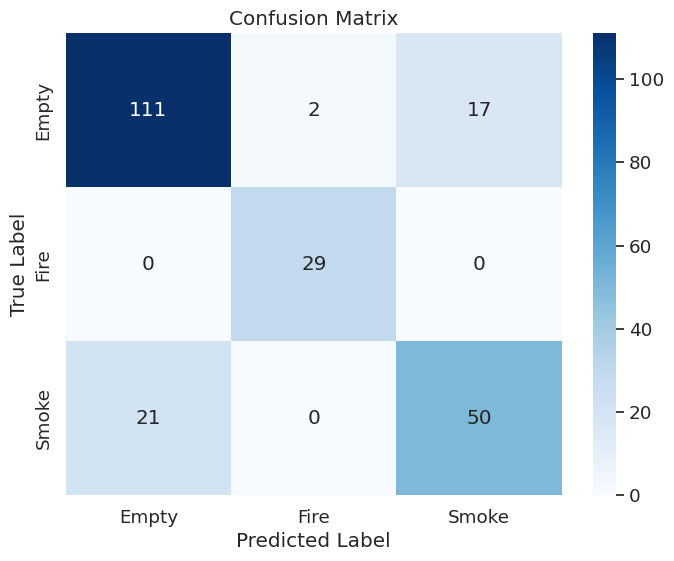

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

labels = ['Empty', 'Fire', 'Smoke']

# Compute the confusion matrix
cm = confusion_matrix(All_groundthruths, pipeline_pred, labels=np.arange(len(labels)))

# Compute precision, recall, and F1-score for each class
report = classification_report(All_groundthruths, pipeline_pred, target_names=labels, output_dict=True)

# Print classification report
print("Classification Report:")
print(classification_report(All_groundthruths, pipeline_pred, target_names=labels))

# Plot the confusion matrix with seaborn heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size for better visualization
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
